<a href="https://colab.research.google.com/github/syedshubha/PulseSCQ/blob/main/QPT_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --quiet qutip qutip-qip matplotlib numpy &> /dev/null

In [2]:
import qutip as qt
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations import Gate, gate_sequence_product
import numpy as np
import matplotlib.pyplot as plt

from itertools import product
import pandas as pd

#No Pulse Attack

In [3]:
theta_vals = np.linspace(0, np.pi, 100)

theory = []
for theta in theta_vals:
    # Prepare input state: cos(theta)|0> + sin(theta)|1>
    state_init = (np.cos(theta) * qt.basis(2, 0) + np.sin(theta) * qt.basis(2, 1)).unit()

    # Projector onto |1>
    P_1 = qt.basis(2, 1) * qt.basis(2, 1).dag()

    # Probability of measuring |1>
    prob_1 = qt.expect(P_1, state_init)
    theory.append(prob_1)

In [4]:
def plotting(theta, fun1, fun2=None):
  plt.figure(figsize=(8, 5))
  if fun2 is None:
    A= "No Attack"
  else:
    A = "pulse attack"
    plt.plot(theta / np.pi, fun2, label='No Attack', color='blue')
  plt.plot(theta / np.pi, fun1, label=A, color='red')
  plt.xlabel(r"Input State Rotation Angle $\theta/\pi$")
  plt.ylabel(r'Probability of measuring $|1\rangle$')
  plt.title(r'$\langle 1 | \psi_\theta \rangle^2$ vs $\theta$')
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()

# Pulse Attack

In [5]:
sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()
I = qt.qeye(2)

def build_adam_state(theta):
    psi_theta = (np.cos(theta) * qt.basis(2, 0) + np.sin(theta) * qt.basis(2, 1)).unit()
    zero = qt.basis(2, 0)
    return qt.tensor(zero, zero, psi_theta)

In [6]:
def pulse_shape(shape="cos", A=1.0, delta=0.0, sigma=0.1, alpha=0.5, chirp_rate=0.0):

    if shape == "cos":
        return lambda t, args: A * np.cos(delta * t)

    elif shape == "gaussian":
        return lambda t, args: A * np.exp(-((t - 0.5)**2) / (2 * sigma**2))

    elif shape == "square":
        return lambda t, args: A if 0.3 <= t <= 0.7 else 0.0

    elif shape == "chirp":
        return lambda t, args: A * np.cos((delta + chirp_rate * t) * t)

    elif shape == "drag":
        return lambda t, args: A * (np.exp(-((t - 0.5)**2)/(2 * sigma**2))
                                   - alpha * (t - 0.5) / sigma**2 * np.exp(-((t - 0.5)**2)/(2 * sigma**2)))

    else:
        raise ValueError(f"Unknown pulse shape: {shape}")


In [7]:
def apply_eve_multi_attack(state_pre, J12=0.1, J01=0.1, A=(1.0, 1.0),
                            delta=(0.0, 0.0), coup_12=(qt.sigmaz(), qt.sigmax()),
                            coup_01=(qt.sigmax(), qt.sigmax()),
                            shape=("cos", "cos"),
                            extra_params=({}, {})):
    A0, A1 = A
    delta0, delta1 = delta
    s1_12, s2_12 = coup_12
    s0_01, s1_01 = coup_01
    shape0, shape1 = shape
    kwargs0, kwargs1 = extra_params

    I = qt.qeye(2)

    # Coupling terms
    H_couple_12 = J12 * qt.tensor(I, s1_12, s2_12)
    H_couple_01 = J01 * qt.tensor(s0_01, s1_01, I)

    # Time-dependent drive terms using pulse_shape function
    coeff0 = pulse_shape(shape=shape0, A=A0, delta=delta0, **kwargs0)
    coeff1 = pulse_shape(shape=shape1, A=A1, delta=delta1, **kwargs1)

    H_p0 = [qt.tensor(qt.sigmax(), I, I), coeff0]
    H_p1 = [qt.tensor(I, qt.sigmax(), I), coeff1]

    H = [H_couple_12, H_couple_01, H_p0, H_p1]

    t_attack = np.linspace(0, 1.0, 50)
    sol = qt.mesolve(H, state_pre, t_attack, [], [])
    return sol.states[-1]


In [8]:
def measure_with_eve(theta_vals, J12=0.1, J01=0.1, A=(1.0, 1.0),
                     delta=(0.0, 0.0), coup_12=(qt.sigmaz(), qt.sigmax()),
                     coup_01=(qt.sigmax(), qt.sigmax()),
                     shape=("cos", "cos"), extra_params=({}, {})):
    probs_attack = []
    for theta in theta_vals:
        state_init = build_adam_state(theta)
        state_post = apply_eve_multi_attack(
            state_init,
            J12=J12, J01=J01,
            A=A, delta=delta,
            coup_12=coup_12, coup_01=coup_01,
            shape=shape, extra_params=extra_params
        )
        state_q2 = state_post.ptrace(2)
        P_1 = qt.basis(2, 1) * qt.basis(2, 1).dag()
        prob_1 = qt.expect(P_1, state_q2)
        probs_attack.append(prob_1)
    return probs_attack

/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


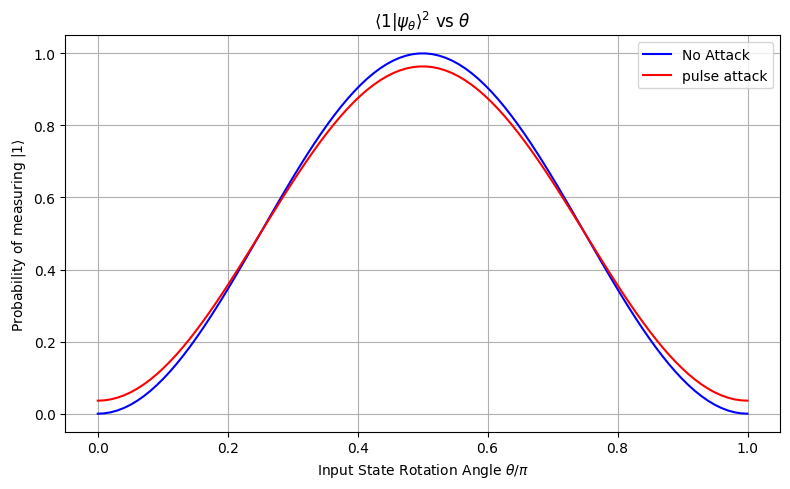

In [9]:
probs_eve = measure_with_eve(theta_vals,
                             J12=0.2,
                             J01=0.1,
                             A=(1.0, 0.5),
                             delta=(0.0, 0.0),
                             coup_12=(qt.sigmaz(), qt.sigmax()),
                             coup_01=(qt.sigmax(), qt.sigmay()))

plotting(theta_vals, probs_eve, theory)

#Finding Dominant Crosstalk Terms

In [10]:
def scan_coupling_and_pulse_effects(theta_vals, pulse_shapes, J12=0.2, J01=0.1, A=(1.0, 1.0), delta=(0.0, 0.0)):
    paulis = {'I': qt.qeye(2), 'X': qt.sigmax(), 'Y': qt.sigmay(), 'Z': qt.sigmaz()}
    results = []

    for k1, k2 in product(paulis.keys(), repeat=2):
        coup_01 = (paulis[k1], paulis[k2])
        for shape in pulse_shapes:
            # Only q1 is attacked: zero amplitude for q0
            probs_q1_only = measure_with_eve(
                theta_vals, J12=J12, J01=J01, A=(0.0, A[1]),
                delta=delta, coup_01=coup_01,
                shape=(shape, shape),  # valid shapes for both
                extra_params=({}, {})
            )

            # Both q0 and q1 are attacked
            probs_q0_q1 = measure_with_eve(
                theta_vals, J12=J12, J01=J01, A=A,
                delta=delta, coup_01=coup_01,
                shape=(shape, shape),
                extra_params=({}, {})
            )

            diff_norm = np.linalg.norm(np.array(probs_q0_q1) - np.array(probs_q1_only))
            results.append((f"{k1}⊗{k2}", shape, diff_norm))

    return pd.DataFrame(results, columns=["Coupling Type (q0⊗q1)", "Pulse Shape", "||Δ|| (Influence)"]).sort_values(
        by="||Δ|| (Influence)", ascending=False).reset_index(drop=True)


In [11]:
J12=0.2
J01=0.1
pulse_shapes = ["cos", "square", "gaussian", "chirp", "drag"]

df_pulse_coupling = scan_coupling_and_pulse_effects(theta_vals, pulse_shapes, J12, J01)
print(df_pulse_coupling.head(10)) #top 10

  Coupling Type (q0⊗q1) Pulse Shape  ||Δ|| (Influence)
0                   Y⊗X       chirp           0.010840
1                   Y⊗X         cos           0.010840
2                   Z⊗X       chirp           0.007278
3                   Z⊗X         cos           0.007278
4                   Y⊗X      square           0.003672
5                   Y⊗X        drag           0.002667
6                   Y⊗X    gaussian           0.001610
7                   Z⊗X        drag           0.001380
8                   Z⊗X      square           0.001221
9                   Z⊗X    gaussian           0.000353
